In [ ]:
!conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia --yes

# DÒNG NÀY TÔI SỬ DỤNG ĐỂ CÀI CÁC THƯ VIỆN CẦN THIẾT TRÊN KAGGLE ĐIỂN HÌNH LÀ PYTORCH 2.5.1
# VÌ ADOPT BẮT BUỘC PYTORCH > 2.5

# NẾU SỬ DỤNG GOOGLE COLAB THÌ CÓ THỂ BỎ QUA DÒNG NÀY 

Retrieving notices: ...working... done
Channels:
 - pytorch
 - nvidia
 - rapidsai
 - nodefaults
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytorch
    - pytorch-cuda=12.4
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aws-c-auth-0.8.0           |      hb88c0a9_10         105 KB  conda-forge
    aws-c-cal-0.8.0            |       hecf86a2_2          46 KB  conda-forge
    aws-c-common-0.10.3        |       hb9d3cd8_0         232 KB  conda-forge
    aws-c-compression-0.3.0    |       hf42f96a_2          19 KB  conda-forge
    aws-c-event-stream-0.5.0   |       h1ffe551_7          52 KB  conda-forge
    aws-c-http-0.9.1           |       hab05fe4_2         192 KB  conda-forge
    aws-c-io-0.15.2            |       hdeadb07_2         156 K

# ADOPT ALGORITHM 1
<img src="https://i.ibb.co/KNRCxTH/Screenshot-2024-12-03-012156.png">

In [3]:
from typing import Optional, Union, Tuple, List, cast, Callable
import torch
from torch.optim.optimizer import Optimizer, ParamsT

from torch import Tensor

from torch.optim.optimizer import (
    _capturable_doc,
    _default_to_fused_or_foreach,
    _device_dtype_check_for_fused,
    _differentiable_doc,
    _disable_dynamo_if_unsupported,
    _foreach_doc,
    _fused_doc,
    _get_capturable_supported_devices,
    _get_scalar_dtype,
    _get_value,
    _maximize_doc,
    _stack_if_compiling,
    _use_grad_for_differentiable,
    _view_as_real,
    DeviceDict,
    Optimizer,
    ParamsT,
)

__all__ = ["ADOPT_ALG1"]

class ADOPT_ALG1(Optimizer):
    def __init__(
        self,
        params: ParamsT,
        lr: Union[float, torch.Tensor] = 1e-3,
        betas: Tuple[float, float] = (0.9, 0.9999),
        eps: float = 1e-6,
        weight_decay: float = 0.0,
        *,
        foreach: Optional[bool] = None,
        maximize: bool = False,
        capturable: bool = False,
        differentiable: bool = False,
        fused: Optional[bool] = None,
        decouple: bool = False,  # Thêm tham số decouple
    ):
        # Kiểm tra giá trị của lr
        if isinstance(lr, torch.Tensor):
            if foreach and not capturable:
                raise ValueError(
                    "lr as a Tensor is not supported for capturable=False and foreach=True"
                )
            if lr.numel() != 1:
                raise ValueError("Tensor lr must be 1-element")

        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= weight_decay:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
        
        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            decouple=decouple,
            maximize=maximize,
            foreach=foreach,
            capturable=capturable,
            differentiable=differentiable,
            fused=fused,
        )
        super().__init__(params, defaults)
    
    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault("maximize", False)
            group.setdefault("foreach", None)
            group.setdefault("capturable", False)
            group.setdefault("differentiable", False)
            fused = group.setdefault("fused", None)
            for p in group["params"]:
                p_state = self.state.get(p, [])
                if len(p_state) != 0 and not torch.is_tensor(p_state["step"]):
                    step_val = float(p_state["step"])
                    p_state["step"] = (
                        torch.tensor(
                            step_val,
                            dtype=_get_scalar_dtype(is_fused=fused),
                            device=p.device,
                        )
                        if group["capturable"] or group["fused"]
                        else torch.tensor(step_val, dtype=_get_scalar_dtype())
                    )

    def _init_group(
        self,
        group,
        params_with_grad,
        grads,
        exp_avgs,
        exp_avg_sqs,
        state_steps,
    ):
        has_complex = False
        for p in group["params"]:
            if p.grad is not None:
                has_complex |= torch.is_complex(p)
                params_with_grad.append(p)
                if p.grad.is_sparse:
                    raise RuntimeError(
                        "ADOPT does not support sparse gradients"
                    )
                grads.append(p.grad)

                state = self.state[p]
                # Lazy state initialization
                if len(state) == 0:
                    if group["fused"]:
                        _device_dtype_check_for_fused(p)
                    # note(crcrpar): [special device hosting for step]
                    # Deliberately host `step` on CPU if both capturable and fused are off.
                    # This is because kernel launches are costly on CUDA and XLA.
                    state["step"] = (
                        torch.zeros(
                            (),
                            dtype=_get_scalar_dtype(is_fused=group["fused"]),
                            device=p.device,
                        )
                        if group["capturable"] or group["fused"]
                        else torch.tensor(0.0, dtype=_get_scalar_dtype())
                    )
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )

                exp_avgs.append(state["exp_avg"])
                exp_avg_sqs.append(state["exp_avg_sq"])

                if group["differentiable"] and state["step"].requires_grad:
                    raise RuntimeError(
                        "`requires_grad` is not supported for `step` in differentiable mode"
                    )

                # Foreach without capturable does not support a tensor lr
                if (
                    group["foreach"]
                    and torch.is_tensor(group["lr"])
                    and not group["capturable"]
                ):
                    raise RuntimeError(
                        "lr as a Tensor is not supported for capturable=False and foreach=True"
                    )

                state_steps.append(state["step"])
        return has_complex

    @_use_grad_for_differentiable
    def step(self, closure=None):
        """Perform a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        self._cuda_graph_capture_health_check()

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad: List[Tensor] = []
            grads: List[Tensor] = []
            exp_avgs: List[Tensor] = []
            exp_avg_sqs: List[Tensor] = []
            state_steps: List[Tensor] = []
            beta1, beta2 = group["betas"]

            has_complex = self._init_group(
                group,
                params_with_grad,
                grads,
                exp_avgs,
                exp_avg_sqs,
                state_steps,
            )

            adopt(
                params_with_grad,
                grads,
                exp_avgs,
                exp_avg_sqs,
                state_steps,
                has_complex=has_complex,
                beta1=beta1,
                beta2=beta2,
                lr=group["lr"],
                weight_decay=group["weight_decay"],
                decouple=group["decouple"],
                eps=group["eps"],
                maximize=group["maximize"],
                foreach=group["foreach"],
                capturable=group["capturable"],
                differentiable=group["differentiable"],
                fused=group["fused"],
                grad_scale=getattr(self, "grad_scale", None),
                found_inf=getattr(self, "found_inf", None),
            )

        return loss



def _single_tensor_adopt(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    state_steps: List[Tensor],
    grad_scale: Optional[Tensor],
    found_inf: Optional[Tensor],
    *,
    has_complex: bool,
    beta1: float,
    beta2: float,
    lr: Union[float, Tensor],
    weight_decay: float,
    decouple: bool,
    eps: float,
    maximize: bool,
    capturable: bool,
    differentiable: bool,
):
    assert grad_scale is None and found_inf is None

    if torch.jit.is_scripting():
        # this assert is due to JIT being dumb and not realizing that the ops below
        # have overloads to handle both float and Tensor lrs, so we just assert it's
        # a float since most people using JIT are using floats
        assert isinstance(lr, float)

    for i, param in enumerate(params):
        grad = grads[i] if not maximize else -grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step_t = state_steps[i]

        # Ensure capturable and differentiable behavior
        if not torch._utils.is_compiling() and capturable:
            capturable_supported_devices = _get_capturable_supported_devices()
            assert (
                param.device.type == step_t.device.type
                and param.device.type in capturable_supported_devices
            ), f"If capturable=True, params and state_steps must be on supported devices: {capturable_supported_devices}."

        # Update step if capturable or differentiable
        step = step_t if capturable or differentiable else _get_value(step_t)

        if weight_decay != 0 and not decouple:
            grad = grad.add(param, alpha=weight_decay)

        # Handle complex numbers
        if torch.is_complex(param):
            grad = torch.view_as_real(grad)
            if exp_avg is not None:
                exp_avg = torch.view_as_real(exp_avg)
            if exp_avg_sq is not None:
                exp_avg_sq = torch.view_as_real(exp_avg_sq)
            param = torch.view_as_real(param)

        # Check if this is the first step for the parameter
        if step == 0:
            exp_avg_sq.addcmul_(grad, grad.conj())
            denom = torch.clamp(exp_avg_sq.sqrt(), eps)
            normed_grad = grad.div(denom)
            exp_avg.add(normed_grad)
            # Update the step
            step_t += 1
            continue

        # Check if this is the first step for the parameter
        if step == 0:
            exp_avg_sq.addcmul_(grad, grad.conj())
            # Update the step
            step_t += 1
            continue

        if weight_decay != 0 and decouple:
            param.add_(param, alpha=-lr*weight_decay)

        # Calculate the denominator using sqrt of exp_avg_sq
        denom = torch.clamp(exp_avg_sq.sqrt(), eps)
        
        # Normalize the gradient by the computed denominator
        normed_grad = grad.div(denom)

        # Compute the exponential moving average of the gradient
        exp_avg.lerp_(normed_grad, 1 - beta1)

        # Update the parameter using the learning rate and exponential average of gradient
        param.add_(exp_avg, alpha=-lr)

        # Update the squared gradient moving average
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)

        # Update step
        step_t += 1
        

@_disable_dynamo_if_unsupported(single_tensor_fn=_single_tensor_adopt)
def adopt(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    state_steps: List[Tensor],
    foreach: Optional[bool] = None,
    capturable: bool = False,
    differentiable: bool = False,
    fused: Optional[bool] = None,
    grad_scale: Optional[Tensor] = None,
    found_inf: Optional[Tensor] = None,
    has_complex: bool = False,
    *,
    beta1: float,
    beta2: float,
    lr: Union[float, Tensor],
    weight_decay: float,
    decouple: bool,
    eps: float,
    maximize: bool,
):
    r"""Functional API that performs ADOPT algorithm computation.

    """
    # Respect when the user inputs False/True for foreach or fused. We only want to change
    # the default when neither have been user-specified. Note that we default to foreach
    # and pass False to use_fused. This is not a mistake--we want to give the fused impl
    # bake-in time before making it the default, even if it is typically faster.
    if fused is None and foreach is None:
        _, foreach = _default_to_fused_or_foreach(
            params, differentiable, use_fused=False
        )
        # Do not flip on foreach for the unsupported case where lr is a Tensor and capturable=False.
        if foreach and isinstance(lr, Tensor) and not capturable:
            foreach = False
    if fused is None:
        fused = False
    if foreach is None:
        foreach = False

    # this check is slow during compilation, so we skip it
    # if it's strictly needed we can add this check back in dynamo
    if not torch._utils.is_compiling() and not all(
        isinstance(t, torch.Tensor) for t in state_steps
    ):
        raise RuntimeError(
            "API has changed, `state_steps` argument must contain a list of singleton tensors"
        )

    if foreach and torch.jit.is_scripting():
        raise RuntimeError("torch.jit.script not supported with foreach optimizers")
    if fused and torch.jit.is_scripting():
        raise RuntimeError("torch.jit.script not supported with fused optimizers")

    # if fused and not torch.jit.is_scripting():
    #     func = _fused_adopt
    # elif foreach and not torch.jit.is_scripting():
    #     func = _multi_tensor_adopt
    # else:
    #     func = _single_tensor_adopt
    func = _single_tensor_adopt

    func(
        params,
        grads,
        exp_avgs,
        exp_avg_sqs,
        state_steps,
        has_complex=has_complex,
        beta1=beta1,
        beta2=beta2,
        lr=lr,
        weight_decay=weight_decay,
        decouple=decouple,
        eps=eps,
        maximize=maximize,
        capturable=capturable,
        differentiable=differentiable,
        grad_scale=grad_scale,
        found_inf=found_inf,
    )



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

In [6]:
def stochastic_gradient(k):
    a = 0
    b = 1
    result = random.choices([a, b], weights=[1.0/k, 1-(1.0/k)])[0]
    
    if result == 0:
        return k**2  
    elif result == 1:
        return -k  

In [7]:
def get_new_learning_rate(t):
    new_lr = 0.01 / ((1+ 0.01 * t) ** 0.5)
    return new_lr

In [8]:
from tqdm import tqdm
import torch

def optimize(k, optimizer_type, beta2, steps):
    values = []  
    theta = torch.nn.Parameter(torch.tensor(0.0, requires_grad=True))  
   
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([theta], betas=(0.9, beta2))
    elif optimizer_type == "AMSGrad":
        optimizer = torch.optim.Adam([theta], betas=(0.9, beta2), amsgrad=True)
    elif optimizer_type == "ADOPT":
        optimizer = ADOPT_ALG1([theta], betas=(0.9, beta2))
        
    # Sử dụng tqdm để hiển thị tiến độ
    for t in tqdm(range(steps), desc=f"Optimizer: {optimizer_type}, k={k}, beta2={beta2}", unit="step"):
        optimizer.zero_grad()  # Xóa gradient cũ

        new_lr = get_new_learning_rate(t + 1)
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr

        # Tính toán loss ngẫu nhiên
        grad = stochastic_gradient(float(k))
        gradient = torch.tensor(grad)
        theta.grad = gradient
        
        optimizer.step()
        
        with torch.no_grad():  # Không tính gradient khi clip
            theta.clamp_(-1, 1)  # Đảm bảo θ ∈ [-1, 1]

        values.append(theta.item())  # Lưu giá trị hiện tại của θ

    return values

In [9]:
list_optimizers = ["Adam", "AMSGrad", "ADOPT"]
list_betas = [0.1, 0.5, 0.999]
steps = 2000000
list_k = [10, 50]
map_result = {}
iter = 0
for k in list_k:
    map_result[k] = {}  # Khởi tạo dictionary con cho mỗi giá trị của k
    for optimizer_type in list_optimizers:
        map_result[k][optimizer_type] = {}  # Khởi tạo dictionary con cho mỗi optimizer_type
        for beta2 in list_betas:
            value = optimize(k, optimizer_type, beta2, steps)
            map_result[k][optimizer_type][beta2] = value  # Lưu giá trị vào dictionary
        iter += 1
        print(iter)

Optimizer: Adam, k=10, beta2=0.999: 100%|██████████| 2000000/2000000 [05:52<00:00, 5670.25step/s]


1


Optimizer: AMSGrad, k=10, beta2=0.999: 100%|██████████| 2000000/2000000 [06:06<00:00, 5456.48step/s]


2


Optimizer: ADOPT, k=10, beta2=0.999: 100%|██████████| 2000000/2000000 [05:35<00:00, 5968.07step/s]


3


Optimizer: Adam, k=50, beta2=0.999: 100%|██████████| 2000000/2000000 [05:50<00:00, 5699.68step/s]


4


Optimizer: AMSGrad, k=50, beta2=0.999: 100%|██████████| 2000000/2000000 [05:59<00:00, 5560.66step/s]


5


Optimizer: ADOPT, k=50, beta2=0.999: 100%|██████████| 2000000/2000000 [05:32<00:00, 6009.18step/s]

6


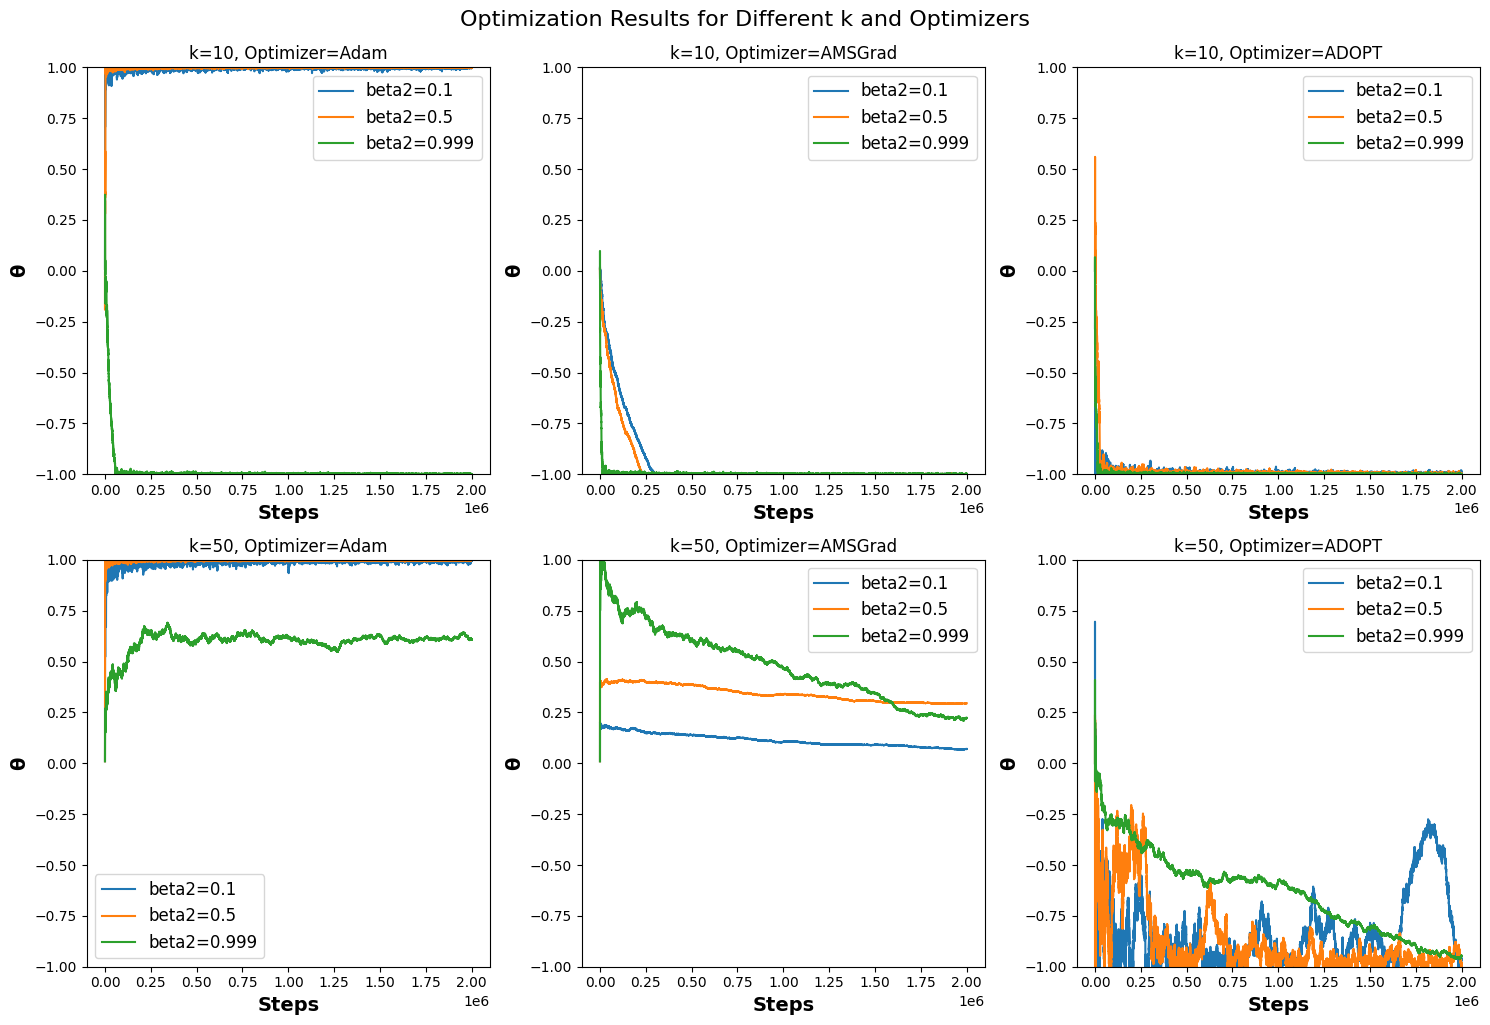

In [11]:
import matplotlib.pyplot as plt

# Giả sử list_k, list_optimizers, list_betas, và map_result đã được định nghĩa

# Vẽ biểu đồ, không chia sẻ trục x và y giữa các biểu đồ
fig, axes = plt.subplots(len(list_k), len(list_optimizers), figsize=(15, 10), sharex=False, sharey=False)

for i, k in enumerate(list_k):
    for j, optimizer in enumerate(list_optimizers):
        ax = axes[i, j]
        for beta2 in list_betas:
            values = map_result[k][optimizer][beta2]
            ax.plot(values, label=f"beta2={beta2}")
        
        # Tùy chỉnh từng biểu đồ
        ax.set_title(f"k={k}, Optimizer={optimizer}", fontsize=12)
        ax.set_xlabel("Steps", fontsize=14, fontweight="bold")
        ax.set_ylabel("θ", fontsize=14, fontweight="bold")
        ax.set_ylim(-1, 1)  # Đặt trục y từ -1 đến 1
        ax.legend(fontsize=12)

# Tùy chỉnh chung
plt.tight_layout()
plt.suptitle("Optimization Results for Different k and Optimizers", y=1.02, fontsize=16)
plt.show()